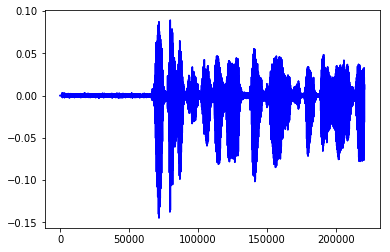

In [1]:
import numpy
import sounddevice as sd
import scipy.io.wavfile as wf
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy.fftpack import dct
import matplotlib.pyplot as plt
%matplotlib inline

sample_rate, signal = wf.read('shubham.wav') # 8kHz
signal = signal[0:int(5 * sample_rate)]  # Keep the first 5 seconds
plt.plot(signal, c='b')
sd.play(signal)

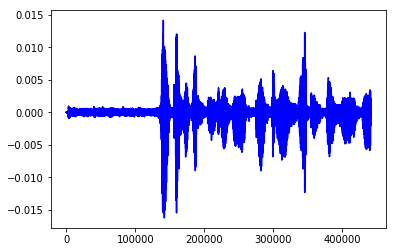

In [2]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1]) #Perfect
plt.plot(emphasized_signal, c='b')
sd.play(emphasized_signal)

1102
(998, 1102)


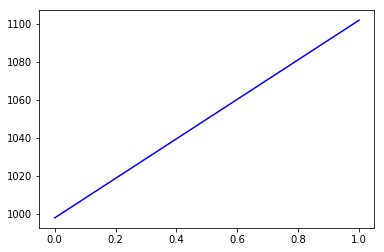

In [3]:
# Split the signal into short-time frames
frame_size = 0.025
frame_stride = 0.01

# Convert from seconds to samples
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate

signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
print(frame_length)
frame_step = int(round(frame_step))
# Make sure that we have at least 1 frame
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z)

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, 
                num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]
frames.shape
plt.plot(frames.shape, c='b')
print(frames.shape)

[[ 0.00000000e+00  0.00000000e+00 -2.44232061e-06 ...  2.44232061e-06
   0.00000000e+00 -2.36816413e-06]
 [ 0.00000000e+00  2.36838587e-06  0.00000000e+00 ...  0.00000000e+00
   2.44163484e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  7.32695485e-08
  -2.36838587e-06 -2.36816413e-06]
 ...
 [-8.41309130e-05 -9.22449614e-05 -9.22708697e-05 ...  3.80025028e-05
   4.03602210e-05  2.85888463e-05]
 [-2.84814239e-04 -2.84840906e-04 -2.49067808e-04 ...  6.07893585e-05
   6.56311565e-05  6.79931790e-05]
 [ 7.96873868e-05  9.05601529e-05  9.30279086e-05 ...  2.13947226e-04
   2.11445518e-04  2.07373053e-04]]


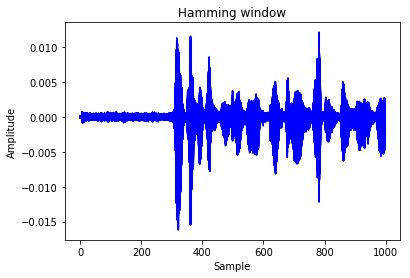

In [4]:
frames *= numpy.hamming(frame_length)
#window = signal.hamming(51)
plt.plot(frames)
plt.title("Hamming window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
#frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation
frames.shape
plt.plot(frames, c='b')
print(frames)

[[6.58469675e-12 7.68819596e-12 7.00142587e-12 ... 1.67870766e-13
  2.56489036e-14 5.81318906e-14]
 [1.68660355e-12 1.54652448e-12 2.13418807e-12 ... 1.14427211e-12
  1.56267910e-12 1.93287458e-12]
 [1.70953319e-12 1.84251495e-12 1.38712701e-12 ... 1.69905786e-12
  1.77853163e-12 1.29010304e-12]
 ...
 [2.30925271e-05 5.05028689e-05 7.24028049e-05 ... 2.20432325e-08
  1.38540508e-08 5.54218478e-09]
 [1.17996554e-05 6.92040766e-06 5.68472530e-06 ... 9.99681932e-10
  2.13912419e-10 4.68118268e-11]
 [8.66125073e-06 6.88054434e-07 2.88285607e-05 ... 2.96264941e-08
  9.15249703e-09 1.21403858e-08]]


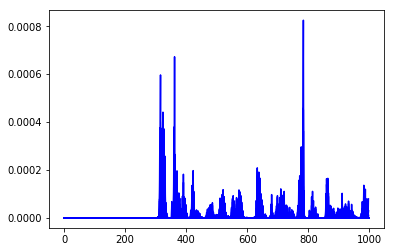

In [16]:
NFFT = 512 # or 256
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2)) 
plt.plot(pow_frames, c='b')
print(pow_frames)

[[-223.62928442 -222.28351112 -223.0962701  ... -175.07995797
  -175.90719159 -194.12835367]
 [-235.4597398  -236.21286402 -233.41534625 ... -177.74877077
  -186.05461649 -195.55052604]
 [-235.34244924 -234.69177958 -237.15767542 ... -169.97746106
  -180.08561751 -188.66515614]
 ...
 [ -92.73057075  -85.93367901  -82.80489217 ... -154.46806015
  -147.78968797 -140.467222  ]
 [ -98.56261353 -103.19736644 -104.90581033 ... -151.71218678
  -149.33672923 -141.41657712]
 [-101.24838778 -123.24754405  -90.80354079 ... -146.55227731
  -144.90014261 -140.66269311]]


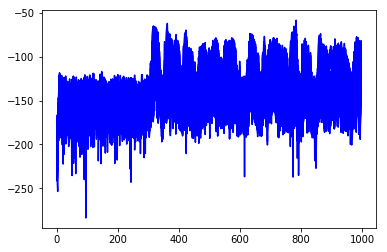

In [21]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB
plt.plot(filter_banks, c='b')
print(filter_banks)

[[-195.62443409  -47.57867957  159.92974777 ...   30.67590971
   154.28775464  -81.30255312]
 [-213.57621334  -57.62271105  171.24068641 ...   89.48439841
   227.06866121  -77.7740713 ]
 [-224.00464313  -71.38947047  164.88431515 ...   27.14849
   267.4761538   -84.59541105]
 ...
 [  50.95279727  117.53161835  209.29197043 ...   21.9034948
    55.83940644   -5.69520255]
 [  16.85055427   49.49536053  139.68994749 ...  197.31471238
   202.75712131  -71.68779058]
 [  14.87778439   54.50343512  169.31292163 ...  -70.94973089
    12.55612654 -159.15534716]]


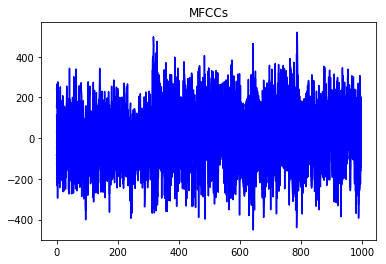

In [42]:
num_ceps = 12
cep_lifter = 22 #refers to the dimensionality of the MFCC vector in the original formulation.

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift
plt.plot(mfcc, c='b')
plt.title("MFCCs")

print(mfcc)

[[ -87.01324331  -93.33673747  -92.27815655 ...   -8.60683365
   -25.11929684  -48.44010903]
 [ -98.84369868 -107.26609038 -102.5972327  ...  -11.27564644
   -35.26672173  -49.8622814 ]
 [ -98.72640813 -105.74500593 -106.33956188 ...   -3.50433674
   -29.29772276  -42.9769115 ]
 ...
 [  43.88547036   43.01309464   48.01322138 ...   12.00506418
     2.99820679    5.22102264]
 [  38.05342758   25.74940721   25.91230322 ...   14.76093755
     1.45116552    4.27166752]
 [  35.36765333    5.6992296    40.01457276 ...   19.92084701
     5.88775214    5.02555153]]


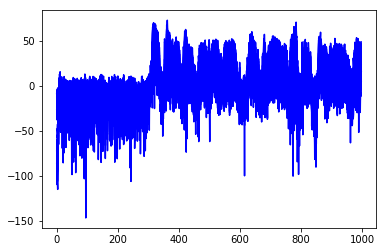

In [23]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)
plt.plot(filter_banks, c='b')
print(filter_banks)